In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

# %cd /content/drive/MyDrive/Colab Notebooks/Kaggle Tubular Playground Series/S4E8 Binary Prediction of Poisonous Mushrooms/

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Kaggle Tubular Playground Series/S4E8 Binary Prediction of Poisonous Mushrooms


In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
import lightgbm as lgb
import eda_util
import matplotlib.pyplot as plt

In [4]:
random_state = 1048576

target = 'loan_status'

# Data Loading

In [5]:
test_csv = pd.read_csv('test.csv', index_col=0)
train_csv = pd.read_csv('train.csv', index_col=0)

In [6]:
train_csv.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [7]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [8]:
test_csv.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [9]:
test_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


# Train-Test Split

In [10]:
X, y = eda_util.feature_target.feature_target_split(train_csv, target=target)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=random_state)

# X_val, X_test, y_val, y_test = train_test_split(
#     X_test, y_test, test_size=0.5, random_state=random_state)
print(f'Shape of X_train is: {X_train.shape}; shape of y_train is: {y_train.shape}')
print(f'Shape of X_test is: {X_test.shape}; shape of y_test is: {y_test.shape}')

Shape of X_train is: (52780, 11); shape of y_train is: (52780,)
Shape of X_test is: (5865, 11); shape of y_test is: (5865,)


# Dealing with outliers

## Loan percentage

In [11]:
loan_income = X_train[['person_income' ,'loan_percent_income', 'loan_amnt']].copy()
loan_income['cal_loan_amnt'] = loan_income['person_income'] * loan_income['loan_percent_income']
loan_income['diff'] = loan_income['cal_loan_amnt'] - loan_income['loan_amnt']
loan_income['percent_diff'] = round(loan_income['diff'] / loan_income['cal_loan_amnt'] * 100, 2)
loan_income[abs(loan_income['percent_diff']) > 50].head(10)

,person_income,loan_percent_income,loan_amnt,cal_loan_amnt,diff,percent_diff
id,,,,,,
12404,1839784,0.04,8000,73591.36,65591.36,89.13
50049,30000,0.00,3200,0.00,-3200.00,-inf
17223,10000,0.08,8000,800.00,-7200.00,-900.00
29893,225000,0.01,3600,2250.00,-1350.00,-60.00
37591,1824000,0.03,6000,54720.00,48720.00,89.04
51496,74000,0.02,12000,1480.00,-10520.00,-710.81
23564,35000,0.04,12200,1400.00,-10800.00,-771.43
30816,72000,0.01,7500,720.00,-6780.00,-941.67
57086,200000,0.13,2800,26000.00,23200.00,89.23


In [12]:
wrong_loan_percent_ind = loan_income[abs(loan_income['percent_diff']) > 50].index
wrong_loan_percent_ind

Index([12404, 50049, 17223, 29893, 37591, 51496, 23564, 30816, 57086, 14081,
       ...
       38110, 15838, 20222, 49179, 54980, 39716, 25959, 44525, 56858, 37534],
      dtype='int64', name='id', length=115)

## Age related

In [13]:
work_time = X_train[['person_age', 'person_emp_length', 'cb_person_cred_hist_length']].copy()
work_time['start_working_age'] = work_time['person_age'] - work_time['person_emp_length']
work_time['start_cred'] = work_time['person_age'] - work_time['cb_person_cred_hist_length']
work_time[work_time['start_working_age'] < 14] # US legal working age starts at 14

,person_age,person_emp_length,cb_person_cred_hist_length,start_working_age,start_cred
id,,,,,
56176,37,28.0,11,9.0,26
3072,24,12.0,2,12.0,22
17542,38,27.0,13,11.0,25
26125,43,41.0,14,2.0,29
48185,23,10.0,3,13.0,20
34852,36,24.0,11,12.0,25
49252,21,123.0,2,-102.0,19
41079,28,123.0,6,-95.0,22
16378,36,24.0,17,12.0,19


In [14]:
wrong_age_ind = work_time[work_time['start_working_age'] < 14].index
wrong_age_ind

Index([56176,  3072, 17542, 26125, 48185, 34852, 49252, 41079, 16378, 32236,
       48118, 33012,   746, 15921, 52038, 18783, 41912, 53992, 43518, 48915,
       18293, 20615,  8222, 12638, 17861, 58602],
      dtype='int64', name='id')

## Dropping the wrong data

In [15]:
drop_ind = np.concatenate([wrong_loan_percent_ind, wrong_age_ind])
drop_ind

array([12404, 50049, 17223, 29893, 37591, 51496, 23564, 30816, 57086,
       14081, 25390, 35301, 58340, 50761, 48803, 33165, 37879, 33686,
       54855, 26911, 34752, 12610, 16134, 37605,  4557, 22647, 15326,
       36720,  3352, 19450, 14314, 37171,  1553, 47434, 18364, 46574,
       22203, 40429, 49051,  5054, 20901, 28328, 35437, 29451,   729,
       37345, 42205, 20632, 53756, 26534, 38167, 50649, 20120, 31093,
        4230,  1296, 51826,  9488, 32724, 11432, 17387, 15679, 52940,
       54527, 54696, 38249, 13872, 40121, 48199, 35808, 19060, 19410,
       32512, 18718, 46500, 57587,  7965, 37541, 34384, 11422, 15454,
       17783, 49038, 38295, 24325, 30309, 52470, 43557, 20271, 53056,
       52674, 50430, 35473, 13744, 11999, 45328, 30528, 10542, 36496,
       34007, 55372, 42939, 38928, 41278, 53133, 38110, 15838, 20222,
       49179, 54980, 39716, 25959, 44525, 56858, 37534, 56176,  3072,
       17542, 26125, 48185, 34852, 49252, 41079, 16378, 32236, 48118,
       33012,   746,

In [16]:
X_train_dropped, y_train_dropped = X_train.drop(drop_ind), y_train.drop(drop_ind)
print(f'X_train shape: {X_train_dropped.shape}')
print(f'y_train shape: {y_train_dropped.shape}')

X_train shape: (52639, 11)
y_train shape: (52639,)


# Categorical Encoder

In [17]:
cat_features = [
    'person_home_ownership', 
    'loan_intent', 
    'loan_grade', 
    'cb_person_default_on_file'
]

num_features = [
    'person_age', 
    'person_income', 
    'person_emp_length', 
    'loan_amnt', 
    'loan_int_rate', 
    'loan_percent_income', 
    'cb_person_cred_hist_length'
]

In [18]:
cat_encoder = ColumnTransformer(
    [
        ('cat_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), cat_features)
    ], 
    remainder='passthrough'
)
cat_encoder.set_output(transform='pandas')
cat_encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_encoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=nan),
                                 ['person_home_ownership', 'loan_intent',
                                  'loan_grade', 'cb_person_default_on_file'])])

In [19]:
X_train_encoded = cat_encoder.fit_transform(X_train_dropped).rename(columns=lambda x:x.split('__', 1)[-1]) # Discard the 'cat_encoder__' and 'passthrough__' prefices
X_train_encoded.head()

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
id,,,,,,,,,,,
40521,3.0,3.0,3.0,0.0,27,35000,3.0,6000,16.29,0.17,7
43239,3.0,3.0,1.0,0.0,27,57500,5.0,9000,12.42,0.16,9
14990,0.0,0.0,0.0,0.0,35,45000,0.0,10000,7.51,0.22,6
18153,0.0,0.0,0.0,0.0,27,60000,12.0,3500,9.32,0.05,7
2715,2.0,5.0,0.0,0.0,36,52000,2.0,8000,7.51,0.15,12


# Model Building

## Base Model

In [45]:
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train_encoded, y_train_dropped, test_size=0.1, random_state=random_state)
print(f'X_train_base shape: {X_train_base.shape}')
print(f'y_train_base shape: {y_train_base.shape}')
print(f'X_val_base shape: {X_val_base.shape}')
print(f'y_val_base shape: {y_val_base.shape}')

X_train_base shape: (47375, 11)
y_train_base shape: (47375,)
X_val_base shape: (5264, 11)
y_val_base shape: (5264,)


In [85]:
base_model = lgb.LGBMClassifier(random_state=random_state)
base_model.fit(X_train_base, y_train_base, categorical_feature=cat_features, eval_set=(X_val_base, y_val_base), eval_metric='auc')
print(f'Training Score: {roc_auc_score(y_train_dropped, base_model.predict_proba(X_train_encoded)[:, 1])}')
print(f'Test Score: {roc_auc_score(y_test, base_model.predict_proba(cat_encoder.transform(X_test))[:, 1])}')

[LightGBM] [Info] Number of positive: 6742, number of negative: 40633
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 47375, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142311 -> initscore=-1.796224
[LightGBM] [Info] Start training from score -1.796224
Training Score: 0.9750531609209179
Test Score: 0.9564988164715792


In [42]:
base_model.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('auc', 0.9643899839566432),
                          ('binary_logloss', 0.13950789537971411)])})

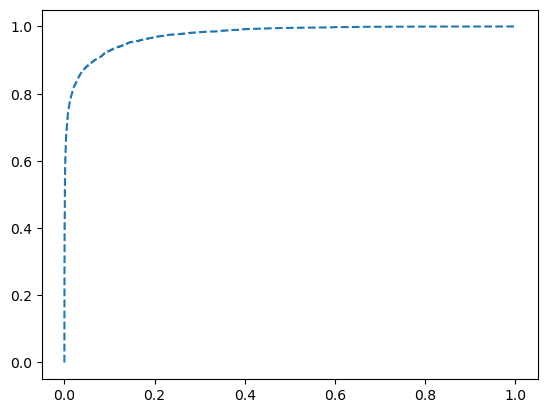

In [29]:
fpr, tpr, thresholds = roc_curve(y_train_dropped, base_model.predict_proba(X_train_encoded)[:,1])
plt.plot(fpr, tpr, linestyle='--')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

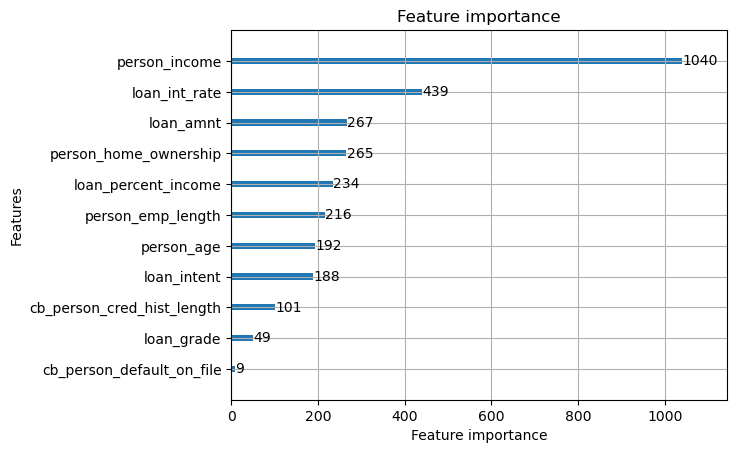

In [21]:
lgb.plot_importance(base_model)

## Bayes Search with 10-fold CV

In [72]:
kf = KFold(n_splits = 10, shuffle = True, random_state = random_state)        # Construct a 10-fold shuffler
clf = lgb.LGBMClassifier(random_state=1048576)                                # Base estimator
opt = BayesSearchCV(clf,                                                      # Param Space
                    {
                        "max_depth": Integer(3, 13),
                        "num_leaves": Integer(20, 200),
                        "min_child_samples": Integer(7, 75),
                        "colsample_bytree": Real(0.25, 1),
                        "subsample": Real(0.25, 1),
                        "subsample_freq": Integer(1, 50),
                        "reg_alpha": Real(0, 1),
                        "reg_lambda": Real(0, 1),
                        "min_split_gain": Real(0, 0.5)
                    },
                    n_iter = 150,
                    cv = kf,
                    n_jobs = 3,
                    random_state = random_state,
                    fit_params={"categorical_feature": cat_features, 
                        "eval_metric": 'auc'},         # Passing categorical features to LGBMClassifier
                   )
opt

BayesSearchCV(cv=KFold(n_splits=10, random_state=1048576, shuffle=True),
              estimator=LGBMClassifier(random_state=1048576),
              fit_params={'categorical_feature': ['person_home_ownership',
                                                  'loan_intent', 'loan_grade',
                                                  'cb_person_default_on_file'],
                          'eval_metric': 'auc'},
              n_iter=150, n_jobs=3, random_state=1048576,
              search_spaces={'colsample_bytree': Real(low=0.25, high=1, p...
                             'num_leaves': Integer(low=20, high=200, prior='uniform', transform='identity'),
                             'reg_alpha': Real(low=0, high=1, prior='uniform', transform='identity'),
                             'reg_lambda': Real(low=0, high=1, prior='uniform', transform='identity'),
                             'subsample': Real(low=0.25, high=1, prior='uniform', transform='identity'),
                             'subsample_freq': Integer(low=1, high=50, prior='uniform', transform='identity')})

In [73]:
opt.fit(X_train_encoded, y_train_dropped)

display(opt.best_estimator_)

print(f'Best parameters are {opt.best_params_}')
print(f'Best score is {opt.best_score_}')

[LightGBM] [Info] Number of positive: 7483, number of negative: 45156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 52639, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142157 -> initscore=-1.797489
[LightGBM] [Info] Start training from score -1.797489


LGBMClassifier(colsample_bytree=0.8220276235753594, max_depth=8,
               min_child_samples=7, min_split_gain=0.5, num_leaves=20,
               random_state=1048576, reg_alpha=1.0, subsample_freq=1)

Best parameters are OrderedDict([('colsample_bytree', 0.8220276235753594), ('max_depth', 8), ('min_child_samples', 7), ('min_split_gain', 0.5), ('num_leaves', 20), ('reg_alpha', 1.0), ('reg_lambda', 0.0), ('subsample', 1.0), ('subsample_freq', 1)])
Best score is 0.9530195782393228


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

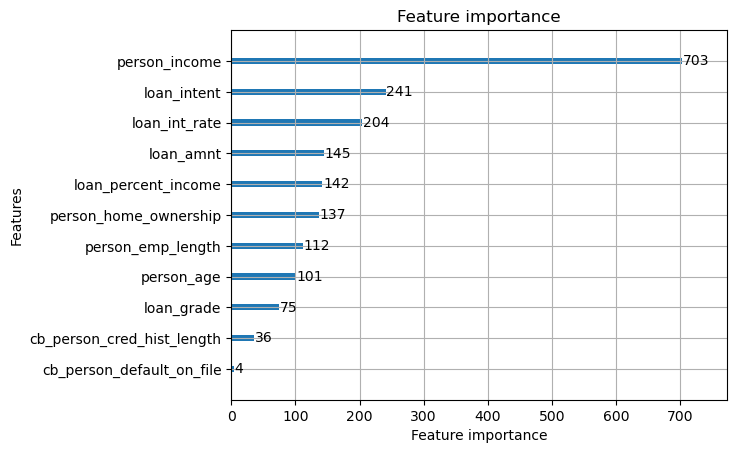

In [74]:
lgb.plot_importance(opt.best_estimator_)

In [78]:
param_dict = {k: v for (k, v) in opt.best_params_.items()}
param_dict

{'colsample_bytree': 0.8220276235753594,
 'max_depth': 8,
 'min_child_samples': 7,
 'min_split_gain': 0.5,
 'num_leaves': 20,
 'reg_alpha': 1.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_freq': 1}

In [79]:
best_lgb = opt.best_estimator_

# best_lgb = LGBMClassifier(**param_dict, random_state=random_state)
# best_lgb.fit(X_train_encoded, y_train_dropped)
# best_lgb

In [80]:
print(f'Test AUC = {roc_auc_score(y_test, best_lgb.predict_proba(cat_encoder.transform(X_test))[:, 1])}')

Test AUC = 0.9571288284192163


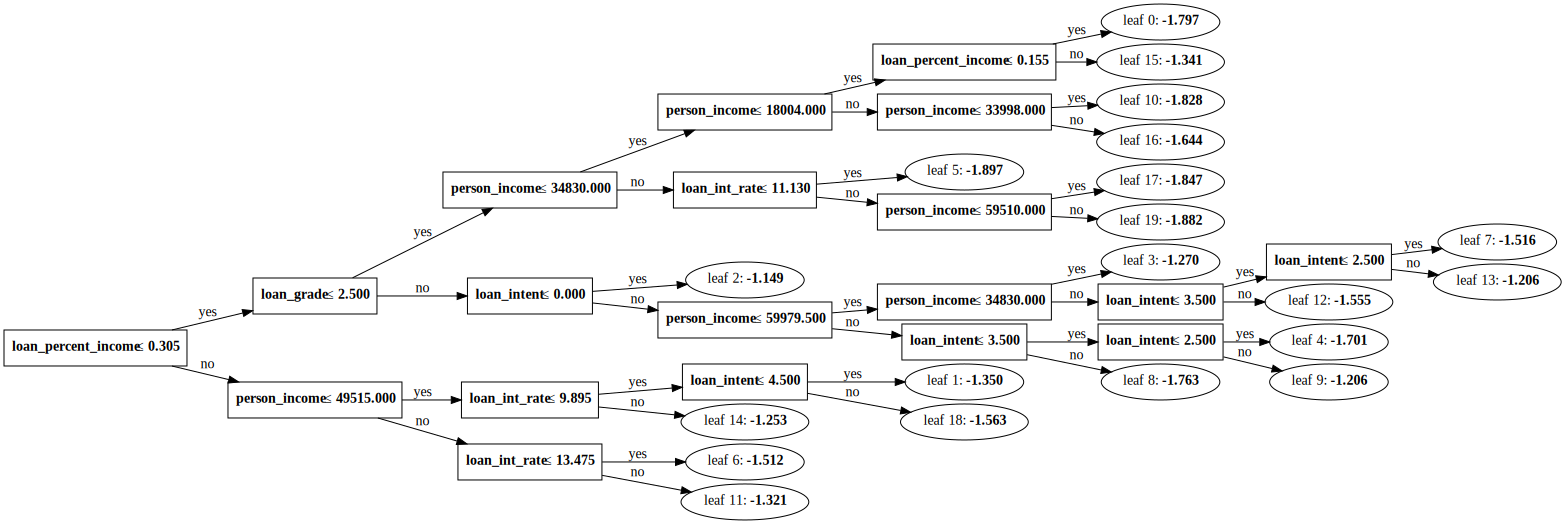

In [81]:
lgb.create_tree_digraph(best_lgb)

# Submit Prediction

## Base Model

In [68]:
cat_encoder.transform(test_csv)

,cat_encoder__person_home_ownership,cat_encoder__loan_intent,cat_encoder__loan_grade,cat_encoder__cb_person_default_on_file,remainder__person_age,remainder__person_income,remainder__person_emp_length,remainder__loan_amnt,remainder__loan_int_rate,remainder__loan_percent_income,remainder__cb_person_cred_hist_length
id,,,,,,,,,,,
58645,3.0,2.0,5.0,0.0,23,69000,3.0,25000,15.76,0.36,2
58646,0.0,4.0,2.0,1.0,26,96000,6.0,10000,12.68,0.10,4
58647,3.0,5.0,4.0,1.0,26,30000,5.0,4000,17.19,0.13,2
58648,3.0,0.0,0.0,0.0,33,50000,4.0,7000,8.90,0.14,7
58649,0.0,2.0,3.0,1.0,26,102000,8.0,15000,16.32,0.15,4
...,...,...,...,...,...,...,...,...,...,...,...
97738,0.0,0.0,1.0,0.0,22,31200,2.0,3000,10.37,0.10,4
97739,0.0,1.0,0.0,0.0,22,48000,6.0,7000,6.03,0.15,3
97740,0.0,4.0,0.0,0.0,51,60000,0.0,15000,7.51,0.25,25


In [54]:
y_pred = base_model.predict_proba(cat_encoder.transform(test_csv))[:, 1]

In [55]:
submission = pd.read_csv('sample_submission.csv', index_col=0)
print(submission.head())
submission[target] = y_pred
print('\n')
print(submission.head())
submission.to_csv('submission_LGBM_base.csv')
print('Result saved successfully!')

       loan_status
id                
58645          0.5
58646          0.5
58647          0.5
58648          0.5
58649          0.5


       loan_status
id                
58645     0.986527
58646     0.013193
58647     0.641350
58648     0.010503
58649     0.066768
Result saved successfully!


In [82]:
y_pred = best_lgb.predict_proba(cat_encoder.transform(test_csv))[:, 1]

In [83]:
submission = pd.read_csv('sample_submission.csv', index_col=0)
print(submission.head())
submission[target] = y_pred
print('\n')
print(submission.head())
submission.to_csv('submission_LGBM_Bayes_proba.csv')
print('Result saved successfully!')

       loan_status
id                
58645          0.5
58646          0.5
58647          0.5
58648          0.5
58649          0.5


       loan_status
id                
58645     0.983749
58646     0.019120
58647     0.532093
58648     0.013113
58649     0.084616
Result saved successfully!
